# 특수문자 손글씨 인식 프로그램

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


# **1. 데이터 세트 제작 파트**

### 최초 코드 기동 시 함수 모음집은 전부 실행하고 진행할 것!

##데이터 세트 글자 구분( ! @ # $ % ^ & * ? + )

#####기본 함수 모음집

In [ ]:
# 1. 최초 설정 함수

def setting() : 
    #그레이 스케일로 변환 
    src = cv2.imread(filename,cv2.IMREAD_GRAYSCALE) 

    #이미지의 크기를 비율 맞춰 조정.
    #기본 수치 744. 안되면 740으로 해보고 그래도 안되면 임의조정.

    changed_width = 744
    n = (src.shape[1] / changed_width)

    changed_height = (src.shape[0] / n)
    src = cv2.resize(src , ( changed_width,int(changed_height) ) ) 

    #양 옆의 노이즈를 제거. 불필요할 시 각주처리할 것.
    #src = src[0:src.shape[0]-10, 5:src.shape[1]-10]

    #영상 이진화 
    ret , binary = cv2.threshold(src,170,255,cv2.THRESH_BINARY_INV) 

    #외곽선 검출
    contours , hierarchy = cv2.findContours(binary , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
 
    #이진화 이미지를 color로 복사한다.
    color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

    #초록색으로 외곽선을 그려준다.
    cv2.drawContours(color , contours , -1 , (0,255,0),3)

    """
    검출한 외곽선에 사각형을 그려서 배열에 추가. 이때 크기가 작은 노이즈는 1차로 거른다.
    boundingRect : 외각선을 감싸는 최소 크기 사각형 반환. x, y는 좌표. w는 폭, h는 넓이.
    append : 리스트에 요소 추가
    """
    bR_arr = [] 

    for i in range(len(contours)) : 
        bin_tmp = binary.copy() 
        x,y,w,h = cv2.boundingRect(contours[i])
        if (x >= 1 and y >= 1) and (w >= 1 and h >= 1) and (w < 100 and h < 100): 
            bR_arr.append([x,y,w,h])

    return bR_arr, bin_tmp, color, src

# 2. 네모 그리기 함수

"""
# 데이터에 사각형그리기. #y축을 기준으로 10개씩 리스트로 묶어서 저장 
# 순서는 !부터 위에서 아래로 10번(count). 그 뒤에 다음 이모티콘을 저장하는 방식.(county)
# countbox는 네모가 쳐진 갯수. 100개면 성공.
"""

def drawrec(bR_arr, color) : 
    # 변수 초기화
    digit_arr = [] 
    digit_arr2 = []
    for n in range(10) : 
        digit_arr2.append([])

    count = 0
    countbox = 0

    # y축으로 정렬
    bR_arr = sorted(bR_arr, key=lambda num : num[1], reverse = False)

    n = 0
    for n in range(10) : 
        bR_arr2 = []
        n1 = (n * 10)
        n2 = n1 + 10

        bR_arr2 = (bR_arr[n1:n2]) 
        bR_arr2 = sorted(bR_arr2, key=lambda num : (num[0]+num[2]/2), reverse = False)

        # 검증. 배열이 정상적으로 들어가는 중인가?
        if  abs(int(bR_arr2[0][0]) - int(bR_arr2[1][0])) < 30 : 
            print("배열 이상 확인, x축 정렬로 이행.")
            return 0

        print(bR_arr2[0:10])

        #자르기!
        for x,y,w,h in bR_arr2 : 
            if y ==0 : 
                tmp_y = bin_tmp[0:y+h+4,x-2:x+w+2].shape[0] #y축 계산
            else :
                tmp_y = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[0] #y축 계산
            
            tmp_x = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[1] #x축 계산

            # ^ 와 * 은 크기가 작으므로 조건없이 별도로 처리하게 세팅.
            # %,는 크기를 넓게 세팅. !와 ?는 x축만 조금 보정.
            # 그 이외는 글자 크기에 맞게 세팅.
            if (tmp_x > 10 or tmp_y > 10) or count == 5 or count == 7 : 
                if count == 0 or count == 8: 
                    if x-4 < 0 :
                        cv2.rectangle(color,(0,y-2),(x+w+4,y+h+2),(0,0,255),1) 
                        digit_arr.append(bin_tmp[y-2:y+h+2,0:x+w+4]) 
                    else : 
                        cv2.rectangle(color,(x-4,y-2),(x+w+4,y+h+2),(0,0,255),1) 
                        digit_arr.append(bin_tmp[y-2:y+h+2,x-4:x+w+4]) 
                elif count == 4 : 
                    if y-10 < 0 : 
                        cv2.rectangle(color,(x-10,0),(x+w+10,y+h+10),(0,0,255),1) 
                        digit_arr.append(bin_tmp[0:y+h+10,x-10:x+w+10])
                    else : 
                        cv2.rectangle(color,(x-10,y-10),(x+w+10,y+h+10),(0,0,255),1) 
                        digit_arr.append(bin_tmp[y-10:y+h+10,x-10:x+w+10])
                else : 
                    if y-2 < 0 : 
                        cv2.rectangle(color,(x-2,0),(x+w+2,y+h+2),(0,0,255),1) 
                        digit_arr.append(bin_tmp[0:y+h+2,x-2:x+w+2]) 
                    else : 
                        cv2.rectangle(color,(x-2,y-2),(x+w+2,y+h+2),(0,0,255),1) 
                        digit_arr.append(bin_tmp[y-2:y+h+2,x-2:x+w+2]) 

                digit_arr2[count].append(digit_arr[0])
                digit_arr = []
                count += 1
                countbox += 1
 
                if count == 10 :
                    count = 0
 
    print("실제로 그어진 네모의 개수 : ", countbox)
    return digit_arr2

# x축 기준 저장.
def drawrec2(bR_arr, color) :

    digit_arr = [] 
    digit_arr2 = [] 

    count = 0
    county = 0
    countbox = 0

    #확실한 배열 순서를 위해 x + w/2를 기준으로 하여 정렬하도록 설정
    bR_arr = sorted(bR_arr, key=lambda num : (num[0] + num[2]/2), reverse = False)

    # 배열 확인
    for n in range(10) : 
        n1 = (n * 10)
        n2 = n1 + 10
        print(bR_arr[n1:n2])

    # 자르기!
    for x,y,w,h in bR_arr : 
        tmp_y = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[0] #y축 계산
        tmp_x = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[1] #x축 계산

        # ^ 와 * 은 크기가 작으므로 조건없이 별도로 처리하게 세팅.
        # %,는 크기를 넓게 세팅. !와 ?는 x축만 조금 보정.
        # 그 이외는 글자 크기에 맞게 세팅.
        if (tmp_x > 10 or tmp_y > 10) or county == 5 or county == 7 : 
                if county == 0 or county == 8: 
                    cv2.rectangle(color,(x-4,y-2),(x+w+4,y+h+2),(0,0,255),1) 
                    digit_arr.append(bin_tmp[y-2:y+h+2,x-4:x+w+4]) 
                elif county == 4 : 
                    if y-10 < 0 : 
                        cv2.rectangle(color,(x-10,0),(x+w+10,y+h+10),(0,0,255),1) 
                        digit_arr.append(bin_tmp[0:y+h+10,x-10:x+w+10])
                    else : 
                        cv2.rectangle(color,(x-10,y-10),(x+w+10,y+h+10),(0,0,255),1) 
                        digit_arr.append(bin_tmp[y-10:y+h+10,x-10:x+w+10])
                else : 
                    if y-2 < 0 : 
                        cv2.rectangle(color,(x-2,0),(x+w+2,y+h+2),(0,0,255),1) 
                        digit_arr.append(bin_tmp[0:y+h+2,x-2:x+w+2]) 
                    else : 
                        cv2.rectangle(color,(x-2,y-2),(x+w+2,y+h+2),(0,0,255),1) 
                        digit_arr.append(bin_tmp[y-2:y+h+2,x-2:x+w+2]) 

                count += 1
                countbox += 1

                if count == 10 : 
                    digit_arr2.append(digit_arr) 
                    digit_arr = [] 
                    count = 0
                    county += 1
                
                if county == 10 :
                    break

    print("실제로 그어진 네모의 개수 : ", countbox)
    return digit_arr2, color

#####인식 보정 함수 모음집

In [ ]:
# 인식용 범위 설정
def changesetting(bR_arr) : 
    erase_dot = []
    count = 0
    county = 0

    # x를 기준으로 정렬
    bR_arr = sorted(bR_arr, key=lambda num : num[0], reverse = False)

    # 네모가 그려질 위치를 미리 파악한다.
    for x,y,w,h in bR_arr : 
        tmp_y = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[0] #y축 계산
        tmp_x = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[1] #x축 계산
        # %는 크기를 넓게 세팅.
        # ^ 와 * 은 크기가 작으므로 조건없이 별도로 처리하게 세팅.
        # 그 이외는 글자 크기에 맞게 세팅.
        if (tmp_x and tmp_y > 20) or county == 5 or county == 7 : 
            erase_dot.append([x,y]) 
            count += 1

            if count == 10 : 
                count = 0
                county += 1

    return erase_dot

# 1. 느낌표 인식 보정
def firstchange(bR_arr,erase_dot) : 
    erase_dot_x_1 = 0

    # 1은 느낌표 범위
    erase_dot = sorted(erase_dot, key=lambda num : num[0], reverse = False)
    erase_dot_x_1 = erase_dot[9][0] + 10
    print("느낌표 적용범위", erase_dot_x_1)

    count = 0

    for i in range(0, len(bR_arr)-1) :
        # y축 차이 계산. 배열수 감소로 에러 시 break하고 다음 i로 이동하게 설정.
        for j in range(i+1, len(bR_arr)-1) :
            try : 
                x_difference = int(bR_arr[i][0]) - int(bR_arr[j][0])
                y_difference = int(bR_arr[i][1]) + int(bR_arr[i][3]) - int(bR_arr[j][1]) - int(bR_arr[j][3])
            except : 
                break

            if int(bR_arr[i][0] ) <= erase_dot_x_1 and int(bR_arr[j][0]) <= erase_dot_x_1 : 
                # x, y의 길이 차가 별로 안 날 것.
                if abs(x_difference) <= 20 and abs(y_difference) <= 50 : 

                    # 높이 비교로 막대기 부분 점 부분 판정.
                    if int(bR_arr[i][3]) < int(bR_arr[j][3]) :
                        # [i]가 점, [j]가 막대기
                        if int(bR_arr[i][3] + bR_arr[i][1] - bR_arr[j][1]) > 0 :
                            bR_arr[j][3] = bR_arr[i][3] + bR_arr[i][1] - bR_arr[j][1] 

                            if (bR_arr[i][0] < bR_arr[j][0]) : 
                                bR_arr[j][0] = bR_arr[i][0]
                                bR_arr[j][2] += bR_arr[i][2]

                            if (bR_arr[i][0] + bR_arr[i][2] > bR_arr[j][0] + bR_arr[j][2] ): 
                                bR_arr[j][2] += bR_arr[i][2]
                                
                            del bR_arr[i]
                            count += 1

                    elif int(bR_arr[i][3]) > int(bR_arr[j][3]) : 
                        # [i]가 막대기, [j]가 점
                        if int(bR_arr[j][3] + bR_arr[j][1] - bR_arr[i][1]) > 0:
                            bR_arr[i][3] = bR_arr[j][3] + bR_arr[j][1] - bR_arr[i][1]

                            if (bR_arr[j][0] < bR_arr[i][0]) : 
                                bR_arr[i][0] = bR_arr[j][0]
                                bR_arr[i][2] += bR_arr[j][2]
                            
                            if (bR_arr[j][0] + bR_arr[j][2] > bR_arr[i][0] + bR_arr[i][2] ) :
                                bR_arr[i][2] += bR_arr[j][2]

                            del bR_arr[j]
                            count += 1

    print("느낌표 보정 적용 수 : ", count)


# 2번. 물음표 인식 보정
def secondchange(bR_arr,erase_dot) : 
    erase_dot_x_2 = 0
    erase_dot_x_3 = 0

    # 물음표 보정 수치.
    length = len(erase_dot) - 100
    print(length)

    # 2,3은 물음표 범위
    for i in range (69+length,len(erase_dot)-1) : 
        if erase_dot[i+1][0] - erase_dot[i][0] >10 :
            erase_dot_x_2 = erase_dot[i+1][0] - 20
            break

    for i in range (89+length,len(erase_dot)-1) : 
        if erase_dot[i+1][0] - erase_dot[i][0] >10 :
            erase_dot_x_3 = erase_dot[i+1][0] + 5
            break

    if erase_dot_x_3 == 0 :
        print("범위 이상 발생으로 임의 범위 설정")
        erase_dot_x_3 = erase_dot[len(erase_dot)-1][0]

    print("물음표 적용범위", erase_dot_x_2, erase_dot_x_3)

    count = 0
    for i in range(0, len(bR_arr)-1) :
        for j in range(i+1, len(bR_arr)-1) :
            try : 
                x_difference = int(bR_arr[i][0]) - int(bR_arr[j][0])
                y_difference = int(bR_arr[i][1]) + int(bR_arr[i][3]) - int(bR_arr[j][1]) - int(bR_arr[j][3])
            except : 
                break

            if int(bR_arr[i][0] ) >= erase_dot_x_2  and int(bR_arr[j][0]) >= erase_dot_x_2  :
                if int(bR_arr[i][0] ) <= erase_dot_x_3  and int(bR_arr[j][0]) <= erase_dot_x_3  : 

                    # x와 y의 길이 차가 별로 안 날 것.
                    if abs(x_difference) <= 25 and abs(y_difference) <= 30: 
                        # 높이 비교로 막대기 부분 점 부분 판정.

                        if int(bR_arr[i][3]) < int(bR_arr[j][3]) :
                            if int(bR_arr[i][3] + bR_arr[i][1] - bR_arr[j][1]) > 0 :
                                # [i]가 점, [j]가 막대기
                                bR_arr[j][3] = bR_arr[i][3] + bR_arr[i][1] - bR_arr[j][1]

                                if bR_arr[i][0] < bR_arr[j][0] : 
                                    bR_arr[j][0] = bR_arr[i][0]
                                    bR_arr[j][2] += bR_arr[i][2]

                                if bR_arr[i][0] +  bR_arr[i][2] > bR_arr[j][0] +  bR_arr[j][2] : 
                                    bR_arr[j][2] += bR_arr[i][2]

                                del bR_arr[i]
                                count += 1

                        elif int(bR_arr[i][3]) > int(bR_arr[j][3]) :                        
                            if int(bR_arr[j][3] + bR_arr[j][1] - bR_arr[i][1]) > 0:
                                # [i]가 막대기, [j]가 점
                                bR_arr[i][3] = bR_arr[j][3] + bR_arr[j][1] - bR_arr[i][1]

                                if bR_arr[j][0] < bR_arr[i][0] : 
                                    bR_arr[i][0] = bR_arr[j][0]
                                    bR_arr[i][2] += bR_arr[j][2]

                                if bR_arr[j][0] +  bR_arr[j][2] > bR_arr[i][0] +  bR_arr[i][2] : 
                                    bR_arr[i][2] += bR_arr[j][2]

                                del bR_arr[j]
                                count += 1

    print("물음표 보정 적용 수 : ", count)
    
    """   
    print("물음표 배열")
    for i in range(0, len(bR_arr)-1) : 
        if int(bR_arr[i][0] ) >= erase_dot_x_2 -1 and int(bR_arr[i][0] ) <= erase_dot_x_3 +1:
            print(bR_arr[i])
    """


# 3번 @, % 문자 보정 및 근처 노이즈 제거

"""
 글자 @와 % 를 보정하자.
 직사각형을 그릴 시, 특수문자 전체만이 아닌 일부까지 인식하는 것을 막도록 노이즈 배열을 제거한다.
 큰 네모와 작은 네모가 있을 때 x 좌표와 y 좌표를 비교 후(x_big < x_small 이고 y_big < y_small 일 것. x와 y를 비교)
 작은 네모가 큰 네모 안에 있는지 비교하고 (x_big_1 > x_small_1 이고 y_big_1 > y_small_1일 것. x+w와 y+h를 비교)
 조건이 맞을 시 작은 네모로 판정된 배열을 제거한다.
"""
def thirdchange(bR_arr,erase_dot) : 
    for i in range(0, len(bR_arr)-1) :
        for j in range(i+1, len(bR_arr)-1) : 
            #베열 파악 중 오류 발생 시 j for문을 break 후 다음 i로 넘기도록 세팅.
            # i가 큰 네모, j가 작은 네모라 가정 후 판단
            try : 
                x_big = int(bR_arr[i][0]) - 10
                y_big = int(bR_arr[i][1]) - 10
                x_small = int(bR_arr[j][0]) 
                y_small = int(bR_arr[j][1])
            except : 
                continue

            if x_big < x_small and y_big < y_small : 
                x_big_1 = int(bR_arr[i][0] + bR_arr[i][2]) + 10
                y_big_1 = int(bR_arr[i][1] + bR_arr[i][3]) + 10
                x_small_1 = int(bR_arr[j][0] + bR_arr[j][2])
                y_small_1 = int(bR_arr[j][1] + bR_arr[j][3])

                if x_big_1 > x_small_1 and y_big_1 > y_small_1 :
                    del bR_arr[j]

            # j가 큰 네모, i가 작은 네모라 가정 후 판단
            try : 
                x_big = int(bR_arr[j][0]) - 10
                y_big = int(bR_arr[j][1]) - 10
                x_small = int(bR_arr[i][0]) 
                y_small = int(bR_arr[i][1])
            except : 
                break

            if x_big < x_small and y_big < y_small : 
                x_big_1 = int(bR_arr[j][0] + bR_arr[j][2]) + 10
                y_big_1 = int(bR_arr[j][1] + bR_arr[j][3]) + 10
                x_small_1 = int(bR_arr[i][0] + bR_arr[i][2])
                y_small_1 = int(bR_arr[i][1] + bR_arr[i][3])

                if x_big_1 > x_small_1 and y_big_1 > y_small_1 :
                    del bR_arr[i]

# 4번 %문자 노이즈 제거 2
def thirdchange1(bR_arr,erase_dot) : 

    # 보정용 변수. 배열 길이 조정.
    length = len(erase_dot) - 100
    erase_dot_x_4 = 0
    erase_dot_x_5 = 0

    # 4,5는 %의 범위
    for i in range (35,len(erase_dot)-1) : 
        if erase_dot[i+1][0] - erase_dot[i][0] > 10 :
            erase_dot_x_4 = erase_dot[i+1][0] - 20
            break

    for i in range (49+length,len(erase_dot)-1) : 
        if erase_dot[i+1][0] - erase_dot[i][0] >10 :
            erase_dot_x_5 = erase_dot[i+1][0] + 5
            break

    print("% 적용범위", erase_dot_x_4, erase_dot_x_5)

    for i in range(0, len(bR_arr)-1) :
        for j in range(i+1, len(bR_arr)-1) : 
            try : 
                x_difference = int(bR_arr[i][0]) - int(bR_arr[j][0])
                y_difference = int(bR_arr[i][1]) + int(bR_arr[i][3]) - int(bR_arr[j][1]) - int(bR_arr[j][3])
            except : 
                break
            
            if int(bR_arr[i][0] ) >= erase_dot_x_4  and int(bR_arr[j][0]) >= erase_dot_x_4  :
                if int(bR_arr[i][0] ) <= erase_dot_x_5  and int(bR_arr[j][0]) <= erase_dot_x_5  : 
                    if abs(x_difference) <= 40 and abs(y_difference) <= 40:

                        # x, y 높이 보정도 같이 진행해보자

                        # j가 동그라미
                        print(bR_arr[i], bR_arr[j])

                        if bR_arr[i][3] > bR_arr[j][3] : 
                            # 왼쪽 동그라미 일 시
                            if bR_arr[i][0] > bR_arr[j][0] : 
                                bR_arr[i][0] = bR_arr[j][0]
                                bR_arr[i][2] = bR_arr[i][2] + bR_arr[j][2]

                            if bR_arr[i][1] > bR_arr[j][1] : 
                                bR_arr[i][1] = bR_arr[j][1]
                                bR_arr[i][3] = bR_arr[i][3] + bR_arr[j][3]

                            # 오른쪽 동그라미 일 시
                            if bR_arr[i][0] < bR_arr[j][0] :
                                if bR_arr[i][0] + bR_arr[i][2] < bR_arr[j][0] + bR_arr[j][2] : 
                                    bR_arr[i][2] += bR_arr[j][2]
                                if bR_arr[i][1] + bR_arr[i][3] < bR_arr[j][1] + bR_arr[j][3] : 
                                    bR_arr[i][3] += bR_arr[j][3]

                            del bR_arr[j]

                        # i가 동그라미
                        elif bR_arr[j][3] > bR_arr[i][3] : 
                            # 왼쪽 동그라미 일 시
                            if bR_arr[j][0] > bR_arr[i][0] : 
                                bR_arr[j][0] = bR_arr[i][0]
                                bR_arr[j][2] = bR_arr[j][2] + bR_arr[i][2]

                            if bR_arr[j][1] > bR_arr[i][1] : 
                                bR_arr[j][1] = bR_arr[i][1]
                                bR_arr[j][3] = bR_arr[j][3] + bR_arr[i][3]

                            # 오른쪽 동그라미 일 시
                            if bR_arr[j][0] < bR_arr[j][0] :
                                if bR_arr[j][0] + bR_arr[j][2] < bR_arr[i][0] + bR_arr[i][2] : 
                                    bR_arr[j][2] += bR_arr[i][2]
                                if bR_arr[j][1] + bR_arr[j][3] < bR_arr[i][1] + bR_arr[i][3] : 
                                    bR_arr[j][3] += bR_arr[i][3]

                            del bR_arr[i]

# 5번 최종 노이즈 제거
def deletenoise(bR_arr) : 
    for i in range(len(bR_arr)) : 
        try : 
            if bR_arr[i][3] < 2 : 
                del bR_arr[i]
        except : 
            break

    print("최종적으로 남은 배열 수 : ", len(bR_arr))

##### 자르기 파트

느낌표 적용범위 70
느낌표 보정 적용 수 :  10
느낌표 적용범위 70
느낌표 보정 적용 수 :  0
느낌표 적용범위 70
느낌표 보정 적용 수 :  0
6
물음표 적용범위 457 621
물음표 보정 적용 수 :  10
6
물음표 적용범위 457 621
물음표 보정 적용 수 :  0
% 적용범위 267 358
[288, 660, 17, 23] [306, 677, 9, 7]
최종적으로 남은 배열 수 :  100
[[58, 34, 6, 40], [111, 32, 34, 41], [183, 36, 25, 39], [245, 28, 17, 48], [300, 38, 24, 35], [367, 45, 19, 18], [426, 26, 27, 53], [477, 47, 29, 18], [551, 40, 13, 32], [621, 41, 21, 26]]
[[53, 114, 14, 42], [98, 110, 43, 40], [175, 115, 26, 35], [242, 107, 24, 46], [296, 119, 21, 33], [371, 135, 13, 15], [431, 121, 27, 38], [496, 133, 21, 21], [567, 122, 14, 32], [621, 120, 29, 27]]
[[60, 205, 6, 40], [106, 210, 40, 31], [184, 206, 24, 36], [238, 200, 22, 45], [294, 204, 23, 30], [372, 214, 16, 15], [432, 207, 26, 40], [491, 212, 22, 23], [571, 200, 12, 31], [616, 207, 25, 27]]
[[50, 294, 8, 38], [100, 293, 39, 35], [177, 291, 24, 30], [241, 286, 17, 40], [296, 297, 22, 27], [368, 300, 15, 19], [434, 286, 27, 35], [497, 289, 32, 20], [577, 283, 16, 34], [

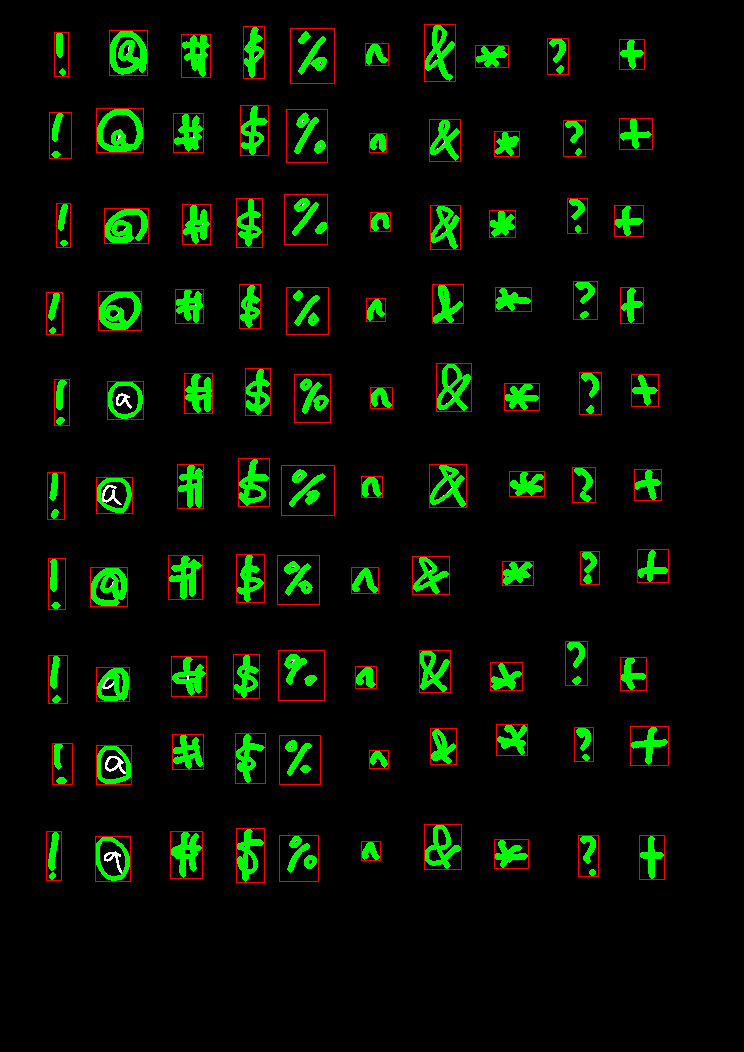

In [ ]:
#필요 함수 import
import cv2 
import numpy as np
from google.colab.patches import cv2_imshow

"""
원활한 이미지 인식을 위한 준비 작업.
"""

# 이미지 파일 경로 지정. 이미지는 camscanner로 흑색보정 후 드라이브에 업로드한다. JPG 일 것!
# @에 인식 문제 발생한 파일. 죄송합니다 다시 올려주세요 목록ㅠㅠㅠㅠ : 141, 146, 149, 151
filename = 'A4/7.jpg'

# 최초 설정
bR_arr, bin_tmp, color, src = setting()

"""
문자 인식 보정
"""

# 인식용 범위 설정
dot = changesetting(bR_arr)

# 느낌표. 3번 반복!
bR_arr = sorted(bR_arr, key=lambda num : num[0], reverse = False)
firstchange(bR_arr,dot)
firstchange(bR_arr,dot)
firstchange(bR_arr,dot)

# 물음표. 2번 반복!
bR_arr = sorted(bR_arr, key=lambda num : num[0], reverse = False)
secondchange(bR_arr,dot)
secondchange(bR_arr,dot)

# %와 @ 및 전체 노이즈 보정.
bR_arr = sorted(bR_arr, key=lambda num : num[0], reverse = False)
thirdchange(bR_arr, dot)
"""
#한번 더 시도! 만일 이미지 수가 이상할 시 이쪽 파트를 주석 처리 해주세요.
"""
bR_arr = sorted(bR_arr, key=lambda num : num[1], reverse = False)
thirdchange(bR_arr, dot)

# % 보정!
bR_arr = sorted(bR_arr, key=lambda num : num[0], reverse = False)
dot = changesetting(bR_arr)
thirdchange1(bR_arr,dot)


# 최종 노이즈 제거
deletenoise(bR_arr)

"""
자르기!
"""

# 자르기 실시. 
digit_arr2 = drawrec(bR_arr, color)

# 이상 감지 시 그림판을 갈아 엎은 후 x축 정렬로 재시도.
if digit_arr2 == 0 : 
    bR_arr_notuse, bin_tmp_notuse, color, src = setting()
    digit_arr2, color = drawrec2(bR_arr, color)

#결과 확인
cv2_imshow(color) 
k = cv2.waitKey(0) 
cv2.destroyAllWindows()

#####데이터 세트 저장

In [ ]:
import os

#리스트에 저장된 이미지를 32x32의 크기로 리사이즈해서 순서대로 저장 
for i in range(0,len(digit_arr2)) : 
    for j in range(len(digit_arr2[i])) :
        # !과 ?의 경우 비율 유지를 위한 마스크 생성
        if i == 0 or i==8: 
            width = digit_arr2[i][j].shape[1]
            height = digit_arr2[i][j].shape[0] 
            tmp = (height - width)/2
            mask = np.zeros((height,height)) 
            mask[0:height,int(tmp):int(tmp)+width] = digit_arr2[i][j]
            digit_arr2[i][j] = cv2.resize(mask,(32,32)) 
        else:
            digit_arr2[i][j] = cv2.resize(digit_arr2[i][j],(32,32))

# 저장 경로 지정
path = 'dataset/'

# 파일 갯수에 따라 자동으로 순번을 매기도록 한다! 기준은 일단 1.
# 첫번째 숫자는 라벨, 두번째 숫자는 그림의 순번을 나타낸다.
file_list = os.listdir(path+'1/')
nextfile = len(file_list)

print("현재 파일 갯수 : ", len(file_list))
print("시작 순번", int(nextfile))

for i in range(0,len(digit_arr2)) : 
    for j in range(len(digit_arr2[i])) :
        labelnum = i
        j1 = int(j + nextfile)
        cv2.imwrite(path + str(labelnum) + '/' + str(labelnum)+'_'+str(j1)+'.png',digit_arr2[i][j])

result = 0
for i in range(0,10) : 
    file_list = os.listdir(path+str(i)+'/')
    result = result + len(file_list)

print("최종 파일 갯수 : ", result)

##데이터 세트 글자 구분2 ( < [ { ( ) } ] > ~ / )

#####기본 함수 모음집

In [ ]:
# 1. 최초 설정 함수

def setting() : 
    #그레이 스케일로 변환 
    src = cv2.imread(filename,cv2.IMREAD_GRAYSCALE) 

    #이미지의 크기를 비율 맞춰 조정.
    #기본 수치 744. 안되면 740으로 해보고 그래도 안되면 임의조정.

    changed_width = 744
    n = (src.shape[1] / changed_width)

    changed_height = (src.shape[0] / n)
    src = cv2.resize(src , ( changed_width,int(changed_height) ) ) 

    #양 옆의 노이즈를 제거. 불필요할 시 각주처리할 것.
    #src = src[0:src.shape[0]-10, 5:src.shape[1]-10]

    #영상 이진화 
    ret , binary = cv2.threshold(src,170,255,cv2.THRESH_BINARY_INV) 

    #외곽선 검출
    contours , hierarchy = cv2.findContours(binary , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
 
    #이진화 이미지를 color로 복사한다.
    color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

    #초록색으로 외곽선을 그려준다.
    cv2.drawContours(color , contours , -1 , (0,255,0),3)

    """
    검출한 외곽선에 사각형을 그려서 배열에 추가. 이때 크기가 작은 노이즈는 1차로 거른다.
    boundingRect : 외각선을 감싸는 최소 크기 사각형 반환. x, y는 좌표. w는 폭, h는 넓이.
    append : 리스트에 요소 추가
    """
    bR_arr_0 = [] 
    count = 0

    for i in range(len(contours)) : 
        bin_tmp = binary.copy() 
        x,y,w,h = cv2.boundingRect(contours[i])
        if (x >= 1 and y >= 1) and (w > 1 and h > 1) and (w <= 100 and h <= 100): 
            bR_arr_0.append([x,y,w,h])

    return bR_arr_0, bin_tmp, color, src

# 2. 네모 그리기 함수

"""
# 데이터에 사각형그리기. #y축을 기준으로 10개씩 리스트로 묶어서 저장 
# 순서는 !부터 위에서 아래로 10번(count). 그 뒤에 다음 이모티콘을 저장하는 방식.(county)
# countbox는 네모가 쳐진 갯수. 100개면 성공.
"""

def drawrec(bR_arr, color) : 
    # 변수 초기화
    digit_arr = [] 
    digit_arr2 = []
    for n in range(10) : 
        digit_arr2.append([])

    count = 0
    countbox = 0

    # y축으로 정렬
    bR_arr = sorted(bR_arr, key=lambda num : num[1], reverse = False)

    n = 0
    for n in range(10) : 
        bR_arr2 = []
        n1 = (n * 10)
        n2 = n1 + 10

        bR_arr2 = (bR_arr[n1:n2]) 
        bR_arr2 = sorted(bR_arr2, key=lambda num : (num[0]+num[2]/2), reverse = False)

        # 검증. 배열이 정상적으로 들어가는 중인가? 
        if  abs(int(bR_arr2[0][0]) - int(bR_arr2[1][0])) < 10 : 
            print("배열 이상 확인, x축 정렬로 이행.")
            print("이상 확인 배열 : ", bR_arr2[0:10])
            print("")
            return 0

        print(bR_arr2[0:10])

        #자르기!
        for x,y,w,h in bR_arr2 : 
            if y ==0 : 
                tmp_y = bin_tmp[0:y+h+4,x-2:x+w+2].shape[0] #y축 계산
            else :
                tmp_y = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[0] #y축 계산
            
            tmp_x = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[1] #x축 계산
            
            # ^ 와 * 은 크기가 작으므로 조건없이 별도로 처리하게 세팅.
            # %,는 크기를 넓게 세팅. !와 ?는 x축만 조금 보정.
            # 그 이외는 글자 크기에 맞게 세팅.
            if (tmp_x >= 10 or tmp_y >= 10) : 
                if y == 0 : 
                    cv2.rectangle(color,(x-2,0),(x+w+2,y+h+2),(0,0,255),1) 
                    digit_arr.append(bin_tmp[0:y+h+2,x-2:x+w+2]) 
                else :  
                    cv2.rectangle(color,(x-2,y-2),(x+w+2,y+h+2),(0,0,255),1) 
                    digit_arr.append(bin_tmp[y-2:y+h+2,x-2:x+w+2]) 

                digit_arr2[count].append(digit_arr[0])
                digit_arr = []
                count += 1
                countbox += 1
 
                if count == 10 :
                    count = 0
 
    print("실제로 그어진 네모의 개수 : ", countbox)
    return digit_arr2

# x축 기준 저장.
def drawrec2(bR_arr, color) :

    digit_arr = [] 
    digit_arr2 = [] 

    count = 0
    county = 0
    countbox = 0

    #확실한 배열 순서를 위해 x + w/2를 기준으로 하여 정렬하도록 설정
    bR_arr = sorted(bR_arr, key=lambda num : (num[0] + num[2]/2), reverse = False)

    # 배열 확인
    for n in range(10) : 
        n1 = (n * 10)
        n2 = n1 + 10
        print(bR_arr[n1:n2])

    # 자르기!
    for x,y,w,h in bR_arr : 
        if y ==0 : 
            tmp_y = bin_tmp[0:y+h+4,x-2:x+w+2].shape[0] #y축 계산
        else :
            tmp_y = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[0] #y축 계산
            
        tmp_x = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[1] #x축 계산

        # ^ 와 * 은 크기가 작으므로 조건없이 별도로 처리하게 세팅.
        # %,는 크기를 넓게 세팅. !와 ?는 x축만 조금 보정.
        # 그 이외는 글자 크기에 맞게 세팅.
        if (tmp_x >= 10 or tmp_y >= 10) and (w >= 4 and h >= 4):
            if y-2 <= 0 : 
                cv2.rectangle(color,(x-2,0),(x+w+2,y+h+2),(0,0,255),1) 
                digit_arr.append(bin_tmp[0:y+h+2,x-2:x+w+2]) 
            else :  
                cv2.rectangle(color,(x-2,y-2),(x+w+2,y+h+2),(0,0,255),1) 
                digit_arr.append(bin_tmp[y-2:y+h+2,x-2:x+w+2]) 

            count += 1
            countbox += 1

        if count == 10 : 
            digit_arr2.append(digit_arr) 
            digit_arr = [] 
            count = 0
            county += 1
                
        if county == 10 :
            break

    print("실제로 그어진 네모의 개수 : ", countbox)
    return digit_arr2, color

#####인식 보정 함수 모음집

In [ ]:
# 인식용 범위 설정
def changesetting(bR_arr) : 
    erase_dot = []
    count = 0
    county = 0

    # x를 기준으로 정렬
    bR_arr = sorted(bR_arr, key=lambda num : num[0], reverse = False)

    # 네모가 그려질 위치를 미리 파악한다.
    for x,y,w,h in bR_arr : 
        tmp_y = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[0] #y축 계산
        tmp_x = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[1] #x축 계산
        # %는 크기를 넓게 세팅.
        # ^ 와 * 은 크기가 작으므로 조건없이 별도로 처리하게 세팅.
        # 그 이외는 글자 크기에 맞게 세팅.
        if (tmp_x and tmp_y > 20) or county == 5 or county == 7 : 
            erase_dot.append([x,y]) 
            count += 1

            if count == 10 : 
                count = 0
                county += 1

    return erase_dot

# 1번 최종 노이즈 제거
def deletenoise(bR_arr, src) :
    for i in range(len(bR_arr)) : 
        try : 
            if (bR_arr[i][2] <= 5 and bR_arr[i][3] <= 5) :
                del bR_arr[i]
        except : 
            break
    return len(bR_arr)

# 2번 최종 노이즈 제거
def deletenoise2(bR_arr, src) : 
    length = len(bR_arr) - 100
    try : 
        max_x = bR_arr[len(bR_arr) - length][0] + bR_arr[len(bR_arr) - length][2]
    except : 
        print("배열이 100개입니다.")
        return len(bR_arr)

    for i in range(len(bR_arr)) : 
        try : 
            if (bR_arr[i][2] <= 5 and bR_arr[i][3] <= 5) or (bR_arr[i][0] >= max_x ) :
                del bR_arr[i]
        except : 
            break

    return len(bR_arr)

# 3번 문자 합치기
def change1(bR_arr,erase_dot) : 

    # 보정용 변수. 배열 길이 조정.
    length = len(erase_dot) - 100
    erase_dot_x_1 = 0

    # 1는 [ < { 의 범위. [중 가장 멀리있는 [ 를 범위 기준으로 삼습니다.
    for i in range (79+length,len(erase_dot)-1) : 
        if erase_dot[i+1][0] - erase_dot[i][0] >10 :
            erase_dot_x_1 = erase_dot[i+1][0] + 5
            break

    print("적용범위", erase_dot_x_1)

    for i in range(0, len(bR_arr)-1) :
        for j in range(i+1, len(bR_arr)-1) :
            # x, y 가 엄청나게 차이 나지 않으면 겹치는 걸로 판정. 
            # 작동 중 에러 날시 반복문 탈출
            try : 
                x_difference = int(bR_arr[i][0]) - int(bR_arr[j][0])
                y_difference = int(bR_arr[i][1]) + int(bR_arr[i][3]) - int(bR_arr[j][1]) - int(bR_arr[j][3])
            except : 
                break
            # 두 배열이 범위 내에 있을 것. 
            if int(bR_arr[i][0] ) <= erase_dot_x_1  and int(bR_arr[j][0]) <= erase_dot_x_1  :
                # 두 배열의 x, y차가 별로 없는가?
                if abs(x_difference) <= 40 and abs(y_difference) <= 50:
                    # i쪽 배열이 문자 위쪽일 시, 아래 쪽(j)의 높이를 위쪽 배열의 높이에 더한 뒤 삭제.
                    if bR_arr[i][1] < bR_arr[j][1] :
                        # x축 잘리는거 보정
                        if bR_arr[j][0] < bR_arr[i][0]:
                            bR_arr[i][0] = bR_arr[j][0]
                        # j쪽의 길이가 더 크면 대체합시다
                        if bR_arr[i][0] + bR_arr[i][2] < bR_arr[j][0] + bR_arr[j][2] :
                            bR_arr[i][2] = bR_arr[j][2]
                        bR_arr[i][3] = bR_arr[i][3] + bR_arr[j][3]
                        del bR_arr[j]

                    # j쪽 배열이 문자 위쪽일 시, 위 쪽(i)의 높이를 아래쪽 배열의 높이에 더한 뒤 삭제.
                    elif bR_arr[j][1] < bR_arr[i][1] : 
                        # x축 잘리는거 보정
                        if bR_arr[j][0] > bR_arr[i][0]:
                            bR_arr[j][0] = bR_arr[i][0]
                        # i쪽의 길이가 더 크면 대체합시다
                        if bR_arr[i][0] + bR_arr[i][2] > bR_arr[j][0] + bR_arr[j][2] :
                            bR_arr[j][2] = bR_arr[i][2]
                        bR_arr[j][3] = bR_arr[j][3] + bR_arr[i][3]
                        del bR_arr[i]

#####자르기 파트

In [ ]:
#필요 함수 import
import cv2 
import numpy as np
from google.colab.patches import cv2_imshow

"""
원활한 이미지 인식을 위한 준비 작업.
만일 글자가 왼쪽에 치우쳐 있다면 기본 함수 모음집 쪽의 setting함수의 16번 줄의 함수를 주석처리해주세요!
그걸로도 인식이 안된다면 42번 줄의 x의 범위를 >=0으로 하고 시도해주세요!
"""
# 이미지 파일 경로 지정. 이미지는 camscanner로 흑색보정 후 드라이브에 업로드한다. JPG 일 것!
filename = 'A4_2/111.jpg'

# 글씨 문제로 보류 : 42, 49, 53, 54, 106, 107, 108, 109, 113, 118, 120
# 저장문제 : 114, 121, 133
# 아까워요 : 111, 115

# 최초 설정
bR_arr, bin_tmp, color, src = setting()
print("최초로 인식된 문자 수 : ", len(bR_arr))

"""
문자 인식 보정
"""
bR_arr = sorted(bR_arr, key=lambda num : (num[0] + num[2]/2), reverse = False)
erase_dot = changesetting(bR_arr)

last = deletenoise(bR_arr, src)
if last > 100 : 
    last = deletenoise2(bR_arr, src)

#change1(bR_arr,erase_dot)

print("최종적으로 남은 배열 수 : ", last)

"""
자르기!
"""

# 자르기 실시. 
digit_arr2 = drawrec(bR_arr, color)

# 이상 감지 시 그림판을 갈아 엎은 후 x축 정렬로 재시도.
if digit_arr2 == 0 : 
    bR_arr_notuse, bin_tmp_notuse, color, src = setting()
    digit_arr2, color = drawrec2(bR_arr, color)

#결과 확인
cv2_imshow(color) 
k = cv2.waitKey(0) 
cv2.destroyAllWindows()

##### 이미지 파일 저장(파일 폴더 별로 분류 시)

In [ ]:
import os

#리스트에 저장된 이미지를 32x32의 크기로 리사이즈해서 순서대로 저장 
for i in range(0,len(digit_arr2)) : 
    for j in range(len(digit_arr2[i])) :
        #print(i,j, digit_arr2[i][j].shape[1], digit_arr2[i][j].shape[0])
        # ~와 /를 제외한 나머지는 비율 유지를 위한 마스크 생성
        if i == 8 or i == 9 : 
            digit_arr2[i][j] = cv2.resize(digit_arr2[i][j],(32,32))
        else:
            width = digit_arr2[i][j].shape[1]
            height = digit_arr2[i][j].shape[0] 
            tmp = (height - width)/2
            mask = np.zeros((height,height)) 
            mask[0:height,int(tmp):int(tmp)+width] = digit_arr2[i][j]
            digit_arr2[i][j] = cv2.resize(mask,(32,32)) 

# 저장 경로 지정
path = 'dataset/'

# 파일 갯수에 따라 자동으로 순번을 매기도록 한다!
# 첫번째 숫자는 라벨, 두번째 숫자는 그림의 순번을 나타낸다.
file_list = os.listdir(path+'11/')
nextfile = len(file_list)

print("현재 파일 갯수 : ", len(file_list))
print("시작 순번", int(nextfile))

for i in range(0,len(digit_arr2)) : 
    for j in range(len(digit_arr2[i])) :
        labelnum = i + 10
        j1 = int(j + nextfile)
        cv2.imwrite(path + str(labelnum) + '/' + str(labelnum)+'_'+str(j1)+'.png',digit_arr2[i][j])

result = 0
for i in range(0,10) : 
    file_list = os.listdir(path+str(i+10)+'/')
    result = result + len(file_list)

print("최종 파일 갯수 : ", result)

# **2. 데이터 모델 제작 파트**

### 데이터 세트 배열 제작

In [ ]:
import os, re, glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터세트 위치 지정
groups_folder_path = 'dataset/'
categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
              "10", "11", "12", "13", "14", "15", "16","17", "18", "19"]
num_classes = len(categories)

# 배열 세팅
X = []
Y = []

# 분류 게시
for idex, categorie in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[idex] = 1
    image_dir = groups_folder_path + categorie + '/'
  
    for top, dir, f in os.walk(image_dir):
        for filename in f:
            img = cv2.imread(image_dir+filename, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(32,32,1)
            X.append(img/255)
            Y.append(label)

            height, width, channel = img.shape
            # 기본, -20도, -20도, 10도, 20도 순으로 회전시키면서 이미지 저장!
            for i in range(4) : 
              if i ==0 : n = -20
              elif i ==1 : n = -10
              elif i ==2 : n = 10
              elif i ==3 : n = 20
    
              matrix = cv2.getRotationMatrix2D((width/2, height/2),n, 1)

              attr_x1 = cv2.warpAffine(img, matrix, (width, height))
              attr_x1 = attr_x1.reshape(32,32,1)

              X.append(attr_x1/255)
              Y.append(label)

            #진행 상황 표시
            msg = "\r파일 : "
            print(msg,image_dir+filename ,end='')
 
X = np.array(X)
Y = np.array(Y)

# 테스트 파일과 훈련 파트 분리. 기본값은 3:1 비율입니다.
train_images,test_images,train_labels,test_labels = train_test_split(X,Y)


# 라벨 설정
class_names = ['!', '@', '#', '$', '%',
               '^', '&', '*', '?', '+',
               '<', '[', '{', '(', ')',
               '}', ']', '>', '~', '/']

# 배열 저장. 테스트 할 때 배열만 불러서 모델 훈련 가능해요!
xy = (train_images,test_images,train_labels,test_labels)

path = 'model/'
np.save(path+'img_data', xy)
np.save(path+'class_data', class_names)

# 파일 형식 표시
print('\n\ndata set shape :',train_images.shape,train_labels.shape,test_images.shape,test_labels.shape)
               
print("데이터 세트 변환 완료")

파일 :  dataset/19/19_409.png

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)




data set shape : (111750, 32, 32, 1) (111750, 20) (37250, 32, 32, 1) (37250, 20)
데이터 세트 변환 완료


### 모델 훈련

배열 불러오는 중...
배열 불러오기 완료

data set shape : (111750, 32, 32, 1) (111750, 20) (37250, 32, 32, 1) (37250, 20)
Epoch 1/42
298/298 [==============================] - 10s 25ms/step - loss: 0.3396 - accuracy: 0.8922 - val_loss: 0.0763 - val_accuracy: 0.9776
Epoch 2/42
298/298 [==============================] - 7s 23ms/step - loss: 0.0518 - accuracy: 0.9834 - val_loss: 0.0588 - val_accuracy: 0.9816
Epoch 3/42
298/298 [==============================] - 7s 23ms/step - loss: 0.0345 - accuracy: 0.9885 - val_loss: 0.0376 - val_accuracy: 0.9882
Epoch 4/42
298/298 [==============================] - 7s 23ms/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.0252 - val_accuracy: 0.9920
Epoch 5/42
298/298 [==============================] - 7s 23ms/step - loss: 0.0188 - accuracy: 0.9937 - val_loss: 0.0223 - val_accuracy: 0.9927
Epoch 6/42
298/298 [==============================] - 7s 23ms/step - loss: 0.0165 - accuracy: 0.9940 - val_loss: 0.0217 - val_accuracy: 0.9928
Epoch 7/42
298/298 [===============

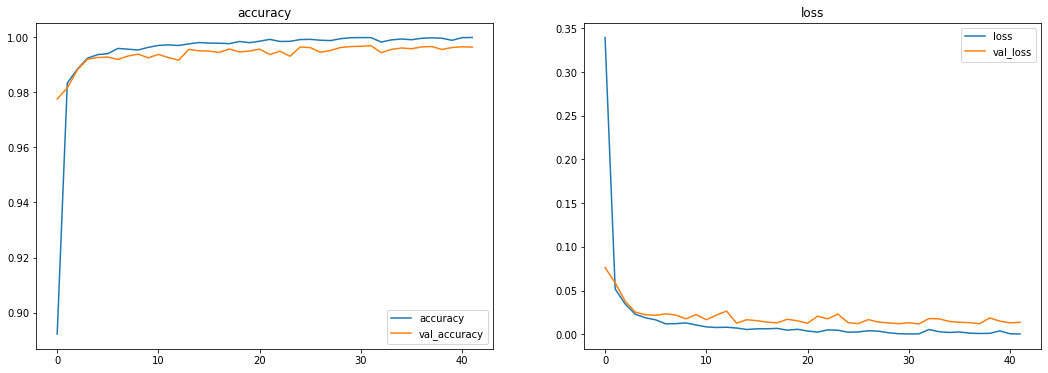

In [ ]:
#모델 훈련
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# 배열 불러오기
print("배열 불러오는 중...")
path = 'model/'
train_images,test_images,train_labels,test_labels = np.load(path+'img_data.npy', allow_pickle=True)
class_names = np.load(path+'class_data.npy')
print("배열 불러오기 완료")

print('\ndata set shape :',train_images.shape,train_labels.shape,test_images.shape,test_labels.shape)

# 모델 객체를 만듭니다
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=train_images.shape[1:] ))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(train_labels.shape[1], activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# 문제는 9000개.
# 모델 훈련하기. 검증 데이터는 0.2 비율로.
# 옵티마이저의 상태를 저장하는 것과 관련되어 경고가 발생할 수 있습니다.
# 이 경고는 (그리고 이 노트북의 다른 비슷한 경고는) 이전 사용 방식을 권장하지 않기 위함이며 무시해도 좋습니다.
history = model.fit(train_images, train_labels, batch_size=300, epochs=42,validation_split=0.2)

# 테스트 이미지로 확인
loss,acc = model.evaluate(test_images,  test_labels)
print("\n테스트 이미지로 계산 결과")
print("손실률: ", loss*100)
print("정확도: ", acc*100)

# 모델 구조를 출력합니다
model.summary()

plt.figure(figsize=(18, 6))

# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("accuracy")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("loss")
plt.legend()

plt.show()

# 전체 모델을 저장합니다
model.save('model/my_model_new.h5')

### 모델 테스트

배열 불러오는 중...
배열 불러오기 완료
data set shape : (37250, 32, 32, 1) (37250, 20)
정답 : )
예측 : )


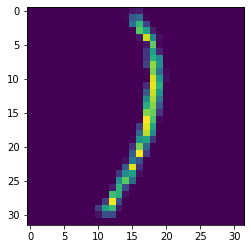

In [ ]:
"""
검증 1(테스트 셋)
"""

# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 검증에 사용할 데이터 준비하기
# 배열 불러오기
print("배열 불러오는 중...")
path = 'model/'
train_images,test_images,train_labels,test_labels = np.load(path+'img_data.npy', allow_pickle=True)
print("배열 불러오기 완료")

print('data set shape :',test_images.shape,test_labels.shape)

# 라벨은 원 핫 디코딩 실시
test_labels = np.argmax(test_labels, axis=1).reshape(-1,1)

# 라벨
class_names = np.load(path+'class_data.npy')

test_labels = np_utils.to_categorical(test_labels)
xhat_idx = np.random.choice(test_images.shape[0], 1)
xhat = test_images[xhat_idx]

xhat_image1 = np.resize(xhat, (32, 32))
plt.imshow(xhat_image1)
plt.show

# 2. 모델 불러오기
from keras.models import load_model
model = load_model('model/my_model_new.h5')

# 3. 모델 사용하기
yhat = model.predict(xhat)
score = tf.nn.softmax(yhat[0])
print('정답 : ' + class_names[ (np.argmax(test_labels[ xhat_idx[0] ]) ) ] )
print("예측 : {}".format(class_names[np.argmax(score)]) )

In [ ]:
"""
검증 2(외부 이미지)
"""

# 필요 라이브러리 호출(PIL은 이미지파일 처리위함)
from keras.models import load_model
import cv2 
import tensorflow as tf
import numpy as np
import sys
import os, re, glob
np.set_printoptions(threshold=sys.maxsize)

# 데이터세트 위치 지정
groups_folder_path = 'test/'
categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
              "10", "11", "12", "13", "14", "15", "16","17", "18", "19"]
num_classes = len(categories)

# 라벨 불러오기
path = 'model/'
print("라벨 불러오는 중...")
class_names = np.load(path+'class_data.npy')
print("라벨 불러오기 완료\n")

# 모델 불러오기
print("모델 불러오는 중...")
model = load_model(path+'my_model_new.h5')
print("모델 불러오기 완료\n")

# 변수 세팅
its_true = 0
its_false = 0
width = 0
height = 0

# 검증 게시
for idex, categorie in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[idex] = 1
    image_dir = groups_folder_path + categorie + '/'

    # 현재 폴더 확인
    print("라벨 : ", class_names[int(categorie)])
  
    for top, dir, f in os.walk(image_dir):
        for filename in f:
          # 이미지 불러오기 및 이미지 사이즈 파악
            src = cv2.imread(image_dir+filename, cv2.IMREAD_GRAYSCALE)
            width = src.shape[1]
            height = src.shape[0]

            #이진화
            ret , binary = cv2.threshold(src,127,255,cv2.THRESH_BINARY_INV)

            #외곽선 검출
            contours , hierarchy = cv2.findContours(binary , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)

            #하얀색으로 외곽선을 그려준 뒤 이진화하고 리사이즈
            cv2.drawContours(binary , contours , -1 , (255,255,255),1)
            color = np.ceil(np.array(binary) / 255) * 255
            color = np.resize(color, (1, 32, 32, 1))

            # 클래스 예측 함수에 가공된 테스트 데이터 넣어 결과 도출
            predictions = model.predict(color)
            score = tf.nn.softmax(predictions[0])
            print(filename, "(", width, ",", height, ") 예측결과 : ", class_names[np.argmax(score)])
            if np.argmax(score) == int(categorie) : 
              its_true += 1
              print("정답")
            else : 
              its_false += 1
              print("오답")
    print("\n")

# 결과
print("정답 갯수 : ", its_true, ", 오답 갯수 : ", its_false)
print('정답을 맞출 확률 : %5.2f%%' %(its_true / (its_true+its_false) * 100))

라벨 불러오는 중...
라벨 불러오기 완료

모델 불러오는 중...
모델 불러오기 완료

라벨 :  !
test0_0.png ( 32 , 32 ) 예측결과 :  }
오답
test0.png ( 32 , 32 ) 예측결과 :  !
정답
testj0.png ( 50 , 50 ) 예측결과 :  $
오답
testh0.png ( 255 , 324 ) 예측결과 :  <
오답
testimage0.png ( 32 , 50 ) 예측결과 :  }
오답
ryu_test0_0.png ( 32 , 28 ) 예측결과 :  !
정답
ryu_test0_1.png ( 31 , 35 ) 예측결과 :  ~
오답
testj0_1.png ( 34 , 34 ) 예측결과 :  $
오답
testj0_2.png ( 40 , 40 ) 예측결과 :  #
오답
testh0_1.png ( 50 , 50 ) 예측결과 :  $
오답
testh0_2.png ( 45 , 45 ) 예측결과 :  #
오답


라벨 :  @
testh1.png ( 1087 , 550 ) 예측결과 :  <
오답
test1.png ( 32 , 32 ) 예측결과 :  @
정답
testimage1.png ( 89 , 56 ) 예측결과 :  &
오답
testj1.png ( 50 , 50 ) 예측결과 :  $
오답
ryu_test1_0.png ( 31 , 35 ) 예측결과 :  &
오답
ryu_test1_1.png ( 42 , 38 ) 예측결과 :  $
오답
testj1_2.png ( 40 , 40 ) 예측결과 :  &
오답
testj1_1.png ( 34 , 34 ) 예측결과 :  #
오답
testh1_1.png ( 50 , 50 ) 예측결과 :  #
오답
testh1_2.png ( 45 , 45 ) 예측결과 :  $
오답


라벨 :  #
testj2.png ( 50 , 50 ) 예측결과 :  #
정답
testimage2.png ( 60 , 84 ) 예측결과 :  <
오답
test2.png ( 32 , 32 ) 예측결과 :  #
정답
ryu_tes